In [0]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K
from keras.preprocessing import image

In [0]:
iv3 = InceptionV3()

In [48]:
ruta_ima_input = "https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg"
!wget "https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg"

--2018-12-29 01:24:50--  https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg
Resolving www.telesurtv.net (www.telesurtv.net)... 131.108.40.130, 179.63.248.14, 190.185.106.220
Connecting to www.telesurtv.net (www.telesurtv.net)|131.108.40.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20705 (20K) [image/jpeg]
Saving to: ‘cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg.2’

cerveza-dia-interna 100%[===================>]  20.22K  --.-KB/s    in 0s      

2018-12-29 01:24:51 (163 MB/s) - ‘cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg.2’ saved [20705/20705]



In [49]:
from pathlib import Path
p = Path(ruta_ima_input)
p.name

'cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg'

[[('n02823750', 'beer_glass', 0.9819864),
  ('n02815834', 'beaker', 0.00413355),
  ('n07930864', 'cup', 0.0013360056),
  ('n04560804', 'water_jug', 0.0012402328),
  ('n03950228', 'pitcher', 0.0009486994)]]

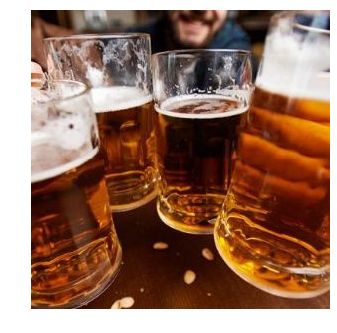

In [50]:
img = image.load_img(p.name, target_size=(299,299))
x = image.img_to_array(img)

plt.axis('off')
plt.imshow(img)


# cambio de rango de 0,255 a -1,1
x = ((x/255.0)-0.5)*2

x = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])

y = iv3.predict(x)

decode_predictions(y)

# Ataque adversario

In [51]:
# interceptar el nodo de entrada y la capa de salida
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# numero correspondiente a un limon
target_class = 951

loss = out_layer[0, target_class]
grad = K.gradients(loss, inp_layer)[0]
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(x)

pert = 1.01
min_pert = x - pert
max_pert = x + pert

cost = 0.0

while cost<0.95:
  
  gr, cost = optimize_gradient([adv,0])
  adv += gr
  adv = np.clip(adv, min_pert, max_pert)
  adv = np.clip(adv, -1, 1)
  print("target cost: ",cost)
  
  

target cost:  9.22936e-05
target cost:  9.331843e-05
target cost:  9.436454e-05
target cost:  9.544365e-05
target cost:  9.654646e-05
target cost:  9.76564e-05
target cost:  9.878478e-05
target cost:  9.994991e-05
target cost:  0.00010113855
target cost:  0.000102348014
target cost:  0.00010359026
target cost:  0.00010487642
target cost:  0.00010619834
target cost:  0.00010754536
target cost:  0.00010891641
target cost:  0.00011032495
target cost:  0.00011175987
target cost:  0.00011321552
target cost:  0.00011469122
target cost:  0.00011619625
target cost:  0.000117756346
target cost:  0.000119365825
target cost:  0.00012100729
target cost:  0.00012267978
target cost:  0.00012441122
target cost:  0.00012620114
target cost:  0.00012804953
target cost:  0.00012993973
target cost:  0.00013188197
target cost:  0.00013388965
target cost:  0.00013595827
target cost:  0.0001380635
target cost:  0.00014020907
target cost:  0.00014242253
target cost:  0.0001446917
target cost:  0.00014705281
t

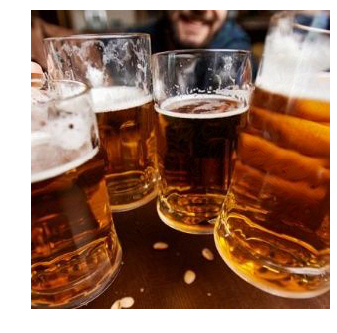

In [52]:

adv_hack2 = ((adv/2.0)+0.5)*255
adv_hack2 = adv_hack2[0].astype(np.uint8)
plt.axis('off')
plt.imshow(adv_hack2)

name_out = 'cerveza_hack.png'
pred_img = image.array_to_img(adv_hack2)
pred_img.save(name_out)



## Probar resultado del ataque 

In [53]:
img_hack = image.load_img(name_out)
x_hack = image.img_to_array(img_hack)


# cambio de rango de 0,255 a -1,1
x_hack = ((x_hack/255.0)-0.5)*2

x_hack = x_hack.reshape(1,x_hack.shape[0],x_hack.shape[1],x_hack.shape[2])

y_hack = iv3.predict(x_hack)

decode_predictions(y_hack)

[[('n07749582', 'lemon', 0.99517256),
  ('n07747607', 'orange', 0.0026342853),
  ('n03062245', 'cocktail_shaker', 0.0001426536),
  ('n04509417', 'unicycle', 0.00013055596),
  ('n07930864', 'cup', 0.0001221634)]]